# _Pythagoras_

Welcome to _Pythagoras_. The goal of this project is to identify and visualize relationships between musical works and composers based on pattern recognition. For more information, visit the [project website](http://web.simmons.edu/~bellanti/pythagoras) or the Github repo.

---

In [5]:
%%HTML
<img src="../database/erd/erd-conceptual.svg" title="Conceptual diagram of Pythagoras"/>

# Table of Contents
* <a href="#Libraries">Libraries</a>
* <a href="#XML">XML</a>
* <a href="#Pandas">Pandas</a>
* <a href="#Regex">Regex</a>
* <a href="#SQLite3">SQLite3</a>
    * <a href="#Create-tables">Create tables</a>
    * <a href="#Insert-values">Insert values</a>
    * <a href="#Queries">Queries</a>
* <a href="#Visualizations">Visualizations</a>

---
# Libraries

<a href="#Table-of-Contents">Return to Table of Contents</a>

---


In [6]:
import pandas as pd
import numpy as np
from lxml import etree
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import csv
import os
from music21 import *

---
# XML

<a href="#Table-of-Contents">Return to Table of Contents</a>

The scores for this project have been converted from PDF files to MusicXML files using [Capella Scan](https://www.capella-software.com/us/index.cfm/products/capella-scan/info-capella-scan/). MusicXML is a standardized encoding format for digital scores; the MusicXML DTD can be found [here](https://www.musicxml.com/for-developers/musicxml-dtd/).

The scores are then converted to CSV files: each <note/> element is represented by a row in the CSV file.

---

In [76]:
d = "/Users/BrandonBel/Desktop/scores/"
xml_d = d + "xml/"
csv_d = d + "csv/"

for path in os.listdir(xml_d):
    xml_filepath = xml_d + path
    csv_filepath = xml_filepath.replace('xml','csv')

    if path.replace('xml','csv') not in os.listdir(csv_d):
        try:
            xml_to_csv(xml_filepath,csv_filepath)
            print("Conversion successful: %s --> %s" % (path, path.replace('xml','csv')))
        except:
            print("Conversion failed: %s " % path)


Conversion failed: Mozart-KV216-3_Rondo.xml 
Conversion successful: Beethoven-01_variation.xml --> Beethoven-01_variation.csv
Conversion successful: Beethoven-1_Horn1.xml --> Beethoven-1_Horn1.csv
Conversion failed: Schubert-Sinfonie Nr 7 - Satz 1.xml 
Conversion failed: Schubert-Sinfonie Nr 7 - Satz 2.xml 


### Get information about the work

In [8]:
print('\nINSTRUMENTATION:\n')

parts = []

for e in root.xpath('//score-part'):
    part = e.xpath('./@id')[0]
    parts.append(part)
    instr = e.xpath('.//instrument-name')[0].text
    print("\t%s (%s)" % (instr,part))


INSTRUMENTATION:

	Midi_2 (P1)
	Midi_2 (P2)


In [9]:
print('\nKEY & TIME\n')

attrib_list = root.xpath("//part[@id='P1']/measure[@number='1']/attributes/*")

key_dict = {
    '-7':'Cb major (Ab minor)',
    '-6':'Gb major (Eb minor)',
    '-5':'Db major (Bb minor)',
    '-4':'Ab major (F minor)',
    '-3':'Eb major (C minor)',
    '-2':'Bb major (G minor)',
    '-1':'F major (D minor)',
    '0':'C major (A minor)',
    '1':'G major (E minor)',
    '2':'D major (B minor)',
    '3':'A major (F# minor)',
    '4':'E major (C# minor)',
    '5':'B major (G# minor)',
    '6':'F# major (D# minor)',
    '7':'C# major (A# minor)'
}

for e in attrib_list:
    if e.tag == 'key':
        accidentals = e.xpath('./fifths')[0].text
        mode = e.xpath('./mode')[0].text
        key = key_dict[accidentals]
        print("\tKey signature:\t", key)
    if e.tag == 'time':
        beats = e.xpath('./beats')[0].text
        val = e.xpath('./beat-type')[0].text
        time = "%s/%s" % (beats,val)
        print("\tTime signature:\t",time)


KEY & TIME

	Key signature:	 D major (B minor)
	Time signature:	 4/4


### Build a dataframe with notes

In [75]:
def xml_to_csv(xml_filepath, csv_filepath):
    tree = etree.parse(xml_filepath)
    root = tree.getroot()

    with open(csv_filepath,'w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(('part','measure','pitch','step','alter','octave','duration','type','dotted','rest','grace','cue'))
        notes = []

        for e in root.xpath('//note'):

            part = e.xpath('../..//@id')[0]

            measure = e.xpath('..//@number')[0]

            dotted = True if 'dot' in [child.tag for child in e] else False

            grace = True if 'grace' in [child.tag for child in e] else False

            cue = True if 'cue' in [child.tag for child in e] else False

            rest = True if 'rest' in [child.tag for child in e] else False

            duration_list = e.xpath('.//duration/text()')
            duration = duration_list[0] if len(duration_list)>0 else ''

            typ_list = e.xpath('.//type/text()')
            typ = typ_list[0] if len(typ_list)>0 else ''

            step_list = e.xpath('.//step/text()')
            step = step_list[0] if len(step_list)>0 else ''

            alter_list = e.xpath('.//alter/text()')
            alter = alter_list[0] if len(alter_list)>0 else ''
            if alter == '0':
                accidental = ''
            elif alter == '-1':
                accidental = 'b'
            elif alter == '1':
                accidental = '#'
            elif alter == '-2':
                accidental = 'bb'
            elif alter == '2':
                accidental = '##'
            else:
                accidental = ''

            pitch = step + accidental

            octave_list = e.xpath('.//octave/text()')
            octave = octave_list[0] if len(step_list)>0 else ''

            # notes.append((part,measure,pitch,step,alter,octave,duration,typ,dotted,rest,grace,cue))
            writer.writerow((part,measure,pitch,step,alter,octave,duration,typ,dotted,rest,grace,cue))


---
# Pandas

<a href="#Table-of-Contents">Return to Table of Contents</a>

---

In [3]:
for file in os.listdir('/Users/BrandonBel/Desktop/scores/csv/'):
    print(file)

Beethoven-Duo2b.csv
Handel-SATZ1.csv
Schubert-D 459, 2 KlavierstÅcke.csv
Beethoven-Opus 22,2.csv
Beethoven-Satz1.csv
Mozart-XI-Menuett.csv
Beethoven-Sonatine Mand c.csv
Schubert-D 002, Fantasie.csv
Beethoven-Opus 101,1.csv
Beethoven-Opus 22,3.csv
Beethoven-Duo2c.csv
Beethoven-op123-2-Gloria.csv
Beethoven-Duo2a.csv
Beethoven-FRöS4.csv
Beethoven-04_variation.csv
Handel-SATZ2.csv
Beethoven-op3_4Adagio.csv
Beethoven-13_variation.csv
Beethoven-Opus 22,1.csv
Beethoven-op3_2Andante.csv
Beethoven-Opus 101,3.csv
Beethoven-Satz2.csv
Beethoven-Andante favori Opus 35.csv
Beethoven-5_viola.csv
Schubert-1_Exposito.csv
Beethoven-Opus 26,4.csv
Handel-SonateNr15_E-Dur.csv
Beethoven-SONAT_1.csv
Beethoven-Satz3.csv
Beethoven-Schweizer_Lied.csv
Beethoven-Opus 101,2.csv
Handel-SATZ3.csv
Beethoven-FRöS2-3.csv
Beethoven-op3_1Allegro con brio.csv
Handel-Sonate_C-Dur_4_Gavotte.csv
Schubert-D 606, Marsch.csv
Beethoven-FRöS1.csv
Beethoven-Wut_Åber_den_verlorenen_Groschen.csv
Handel-SonateNr12_F-Dur.csv
Schubert-

In [23]:

for path in os.listdir(file_dir):
    infile_path = file_dir + path
    outfile_path = infile_path.replace('/csv/','/patterns/')
    print(infile_path)
    print(outfile_path)
    print()


/Users/BrandonBel/Desktop/MusicXML_scores/csv/Beethoven-Duo2b.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Beethoven-Duo2b-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Handel-SATZ1.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Handel-SATZ1-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Schubert-D 459, 2 KlavierstÅcke.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Schubert-D 459, 2 KlavierstÅcke-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Beethoven-Opus 22,2.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Beethoven-Opus 22,2-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Beethoven-Satz1.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Beethoven-Satz1-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Mozart-XI-Menuett.csv
/Users/BrandonBel/Desktop/MusicXML_scores/patterns/Mozart-XI-Menuett-patterns.csv

/Users/BrandonBel/Desktop/MusicXML_scores/csv/Beethoven-Sonatine Mand c.csv
/Use

In [ ]:
file_dir = '/Users/BrandonBel/Desktop/scores/csv/'
completed_files = os.listdir('/Users/BrandonBel/Desktop/scores/patterns/')

composer = "Handel"

with open('logfile.csv','a') as logfile:
    logwriter = csv.writer(logfile)
#     logwriter.writerow(('file','status'))

    for path in os.listdir(file_dir):
        infile_path = file_dir + path
        outfile_path = infile_path.replace('/csv/','/patterns/')
        
        if composer in path:
            if path not in completed_files:
                try:
                    print(path)
                    df = read_df(infile_path)
                    string_dict = series_to_string_dict(df)
                    pattern_list = find_patterns(string_dict, min_length=3, min_occur=3)

                    with open(outfile_path,'w') as outfile:
                        for pattern in pattern_list:
                            outfile.write(pattern+'\n')
                    logwriter.writerow((path,'complete'))
                except:
                    continue
                print()
print('COMPLETE')

In [191]:
df
df.to_csv('/Users/BrandonBel/Desktop/test.csv')

In [39]:
pitch_dict = {'A0':'1','G##0':'1','Bbb0':'1','A#0':'2','Bb0':'2','Cbb1':'2','B0':'3','Cb1':'3','A##0':'3','C1':'4','B#0':'4','Dbb1':'4','C#1':'5','Db1':'5','B##1':'5','D1':'6','C##1':'6','Ebb1':'6','D#1':'7','Eb1':'7','Fbb1':'7','E1':'8','Fb1':'8','D##1':'8','1':'8','F1':'9','E#1':'9','Gbb1':'9','F#1':'10','Gb1':'10','E##1':'10','G1':'11','F##1':'11','Abb1':'11','G#1':'12','Ab1':'12','A1':'13','G##1':'13','Bbb1':'13','A#1':'14','Bb1':'14','Cbb1':'14','B1':'15','Cb1':'15','A##1':'15','C2':'16','B#1':'16','Dbb2':'16','C#2':'17','Db2':'17','B##2':'17','D2':'18','C##2':'18','Ebb2':'18','D#2':'19','Eb2':'19','Fbb2':'19','E2':'20','Fb2':'20','D##2':'20','2':'20','F2':'21','E#2':'21','Gbb2':'21','F#2':'22','Gb2':'22','E##2':'22','G2':'23','F##2':'23','Abb2':'23','G#2':'24','Ab2':'24','A2':'25','G##2':'25','Bbb2':'25','A#2':'26','Bb2':'26','Cbb2':'26','B2':'27','Cb2':'27','A##2':'27','C3':'28','B#2':'28','Dbb3':'28','C#3':'29','Db3':'29','B##3':'29','D3':'30','C##3':'30','Ebb3':'30','D#3':'31','Eb3':'31','Fbb3':'31','E3':'32','Fb3':'32','D##3':'32','3':'32','F3':'33','E#3':'33','Gbb3':'33','F#3':'34','Gb3':'34','E##3':'34','G3':'35','F##3':'35','Abb3':'35','G#3':'36','Ab3':'36','A3':'37','G##3':'37','Bbb3':'37','A#3':'38','Bb3':'38','Cbb3':'38','B3':'39','Cb3':'39','A##3':'39','C4':'40','B#3':'40','Dbb4':'40','C#4':'41','Db4':'41','B##4':'41','D4':'42','C##4':'42','Ebb4':'42','D#4':'43','Eb4':'43','Fbb4':'43','E4':'44','Fb4':'44','D##4':'44','4':'44','F4':'45','E#4':'45','Gbb4':'45','F#4':'46','Gb4':'46','E##4':'46','G4':'47','F##4':'47','Abb4':'47','G#4':'48','Ab4':'48','A4':'49','G##4':'49','Bbb4':'49','A#4':'50','Bb4':'50','Cbb4':'50','B4':'51','Cb4':'51','A##4':'51','C5':'52','B#4':'52','Dbb5':'52','C#5':'53','Db5':'53','B##5':'53','D5':'54','C##5':'54','Ebb5':'54','D#5':'55','Eb5':'55','Fbb5':'55','E5':'56','Fb5':'56','D##5':'56','5':'56','F5':'57','E#5':'57','Gbb5':'57','F#5':'58','Gb5':'58','E##5':'58','G5':'59','F##5':'59','Abb5':'59','G#5':'60','Ab5':'60','A5':'61','G##5':'61','Bbb5':'61','A#5':'62','Bb5':'62','Cbb5':'62','B5':'63','Cb5':'63','A##5':'63','C6':'64','B#5':'64','Dbb6':'64','C#6':'65','Db6':'65','B##6':'65','D6':'66','C##6':'66','Ebb6':'66','D#6':'67','Eb6':'67','Fbb6':'67','E6':'68','Fb6':'68','D##6':'68','6':'68','F6':'69','E#6':'69','Gbb6':'69','F#6':'70','Gb6':'70','E##6':'70','G6':'71','F##6':'71','Abb6':'71','G#6':'72','Ab6':'72','A6':'73','G##6':'73','Bbb6':'73','A#6':'74','Bb6':'74','Cbb6':'74','B6':'75','Cb6':'75','A##6':'75','C7':'76','B#6':'76','Dbb7':'76','C#7':'77','Db7':'77','B##7':'77','D7':'78','C##7':'78','Ebb7':'78','D#7':'79','Eb7':'79','Fbb7':'79','E7':'80','Fb7':'80','D##7':'80','7':'80','F7':'81','E#7':'81','Gbb7':'81','F#7':'82','Gb7':'82','E##7':'82','G7':'83','F##7':'83','Abb7':'83','G#7':'84','Ab7':'84','A7':'85','G##7':'85','Bbb7':'85','A#7':'86','Bb7':'86','Cbb8':'86','B7':'87','Cb8':'87','A##7':'87','C8':'88','B#7':'88','Dbb8':'88'}

In [24]:
def read_df(infile_path):
    
    df = pd.read_csv(infile_path)
    df['octave'] = df['octave'].loc[df['octave'].notna()].astype(int).astype(str)
    df['keyboard_step'] = df['pitch'] + df['octave']
    df['keyboard_step'].fillna('', inplace=True)
    df['keyboard_step'] = df['keyboard_step'].apply(lambda x: int(pitch_dict[x]) if len(x)>0 else None)
    df['interval'] = df['keyboard_step'].diff()

    return df

---
# Regex

<a href="#Table-of-Contents">Return to Table of Contents</a>

---

Using the string generated from the dataframe series, match any reoccuring patterns longer than a given length.

In [5]:
def series_to_string_dict(df):
        
    string_dict = {}
    parts = df['part'].unique()
    
    for part in parts:
        part_df = df[df['part'] == part].fillna('')
        steps = part_df['interval'].to_string(index=False, header=False)

        # steps = re.sub(r'\n|\t| ','',steps)
        steps = re.sub(r'\n','.',steps)
        steps = re.sub(r' ','',steps)
    
        string_dict[part] = steps
        
    return string_dict

series_to_string_dict(df)

In [18]:
def find_patterns(string_dict, min_length, min_occur):
    pattern_list = []
    for part in string_dict:
        string = string_dict[part]
        pat = r'((?<=\.)[^.]+\.(?:[^.]*\.){%d,}[^.]+(?=\.))(?:.*\1){%d,}' % (min_length-2, min_occur-1)
        patterns = re.findall(pat,string,overlapped=True)
        for pattern in patterns:
            if pattern not in pattern_list:
                pattern_list.append(pattern)
        print("Completed:",part)

    for pattern in pattern_list:
        max_length = len(pattern.split('.'))
        for length in range(max_length-1,min_length-1,-1):
            pat = r'(^[^.]+\.(?:[^.]*\.){%d}[^.]+)' % (length-2)
            alt_patterns = re.findall(pat,pattern,overlapped=True)
            for alt_pattern in alt_patterns:
                if alt_pattern not in pattern_list:
                    pattern_list.append(alt_pattern)

    return pattern_list

In [33]:
pattern_list = find_patterns(series_to_string_dict(df), min_length=2, min_occur=4)

with open(outfile_path,'w') as outfile:
    for pattern in pattern_list:
        outfile.write(pattern+'\n')

Completed: P1
Completed: P2
Completed: P3


In [27]:
def df_to_pattern_list(df):
    string_dict = series_to_string_dict(df)
    pattern_list = find_patterns(string_dict,min_length=4,min_occur=3)
    return pattern_list

patterns = df_to_pattern_list(df)

Completed: P1


---
# SQLite3

<a href="#Table-of-Contents">Return to Table of Contents</a>

---

[SQLite3 documentation](https://docs.python.org/3.7/library/sqlite3.html)

In [9]:
import sqlite3
conn = sqlite3.connect('pythagoras.db')
c = conn.cursor()

## Create tables

In [84]:
c.execute('''CREATE TABLE IF NOT EXISTS work (
    work_id INTEGER PRIMARY KEY AUTOINCREMENT,
    work_title text,
    work_composer text
    );''')
conn.commit()

In [16]:
c.execute('''CREATE TABLE IF NOT EXISTS pattern (
    pattern_id INTEGER PRIMARY KEY AUTOINCREMENT,
    pattern_string text
    );''')
conn.commit()

In [17]:
c.execute('''CREATE TABLE IF NOT EXISTS work_pattern (
    work_id INTEGER,
    pattern_id INTEGER,
    FOREIGN KEY (work_id) REFERENCES work(work_id),
    FOREIGN KEY (pattern_id) REFERENCES pattern(pattern_id)
    );''')
conn.commit()

In [4]:
# show tables
print(c.execute('''SELECT name from sqlite_master where type="table";''').fetchall())

# show columns
print(c.execute('''PRAGMA table_info(pattern);''').fetchall())

[('work',), ('sqlite_sequence',), ('pattern',), ('work_pattern',)]
[(0, 'pattern_id', 'INTEGER', 0, None, 1), (1, 'pattern_string', 'text', 0, None, 0)]


In [14]:
# c.execute('''DROP TABLE IF EXISTS work;''')
c.execute('''DROP TABLE IF EXISTS pattern;''')
c.execute('''DROP TABLE IF EXISTS work_pattern;''')

## Insert values

In [84]:
files = os.listdir("/Users/BrandonBel/Desktop/scores/csv/")
for file in files:
    try:
        m = re.match(r'(\w*?)-(.*).csv',file)
        composer = m.group(1)
        title = m.group(2)
#         print("\nComposer:", composer, "\nTitle: ", title)
        
        if c.execute('''SELECT COUNT(work_title) FROM work WHERE work_title=(?)''', (title,)).fetchone()[0] == 0:
            c.execute('''INSERT INTO work(work_title, work_composer) VALUES (?,?)''',(title,composer))

    except:
        print("Cannot match: %s" % file)
        
conn.commit()

Cannot match: .DS_Store


In [5]:
dir_path = "/Users/BrandonBel/Desktop/scores/patterns/"
pattern_files = os.listdir(dir_path)

for path in pattern_files:
    try:
        m = re.match(r'(\w*?)-(.*).csv',path)
        composer = m.group(1)
        title = m.group(2)
        work_id = c.execute('''SELECT work_id FROM work WHERE work_title=(?)''', (title,)).fetchone()[0]
        print("\nComposer:", composer, "\nTitle:", title,"\nDB ID:",work_id)

        with open(dir_path+path,'r') as pattern_file:
            for line in pattern_file:
                pattern_string = line.rstrip()
    #             if c.execute('''SELECT COUNT(pattern_id) FROM pattern WHERE pattern_string=(?);''', (pattern_string,)).fetchone()[0] == 0:
    #                 c.execute('''INSERT INTO pattern(pattern_string) VALUES (?);''',(pattern_string,))
                try:
                    pattern_id = c.execute('''SELECT pattern_id FROM pattern WHERE pattern_string=(?);''', (pattern_string,)).fetchone()[0]
                except:
                    c.execute('''INSERT INTO pattern(pattern_string) VALUES (?);''',(pattern_string,))
                    pattern_id = c.execute('''SELECT pattern_id FROM pattern WHERE pattern_string=(?);''', (pattern_string,)).fetchone()[0]


    #                 print("\t",pattern_id, pattern_string)
    #                 if c.execute('''SELECT COUNT(work_id) FROM work_pattern WHERE work_id=(?) AND pattern_id=(?);''', (work_id,pattern_id)).fetchone()[0] == 0:
    #                     c.execute('''INSERT INTO work_pattern(work_id, pattern_id) VALUES (?,?);''',(work_id,pattern_id))
                c.execute('''INSERT INTO work_pattern(work_id, pattern_id) VALUES (?,?);''',(work_id,pattern_id))
            print('Status: Complete')
            conn.commit()
    except:
        print('\n',"*"*80)
        print("Can't find title:",path)
        print("*"*80,'\n')


conn.commit()


Composer: Beethoven 
Title: Duo2b 
DB ID: 1
Status: Complete

Composer: Handel 
Title: SATZ1 
DB ID: 2
Status: Complete

Composer: Beethoven 
Title: Satz1 
DB ID: 5
Status: Complete

Composer: Mozart 
Title: XI-Menuett 
DB ID: 6
Status: Complete

Composer: Beethoven 
Title: Sonatine Mand c 
DB ID: 7
Status: Complete

Composer: Schubert 
Title: D 002, Fantasie 
DB ID: 8
Status: Complete

Composer: Beethoven 
Title: Opus 101,1 
DB ID: 9
Status: Complete

Composer: Beethoven 
Title: Opus 22,3 
DB ID: 10
Status: Complete

Composer: Beethoven 
Title: Duo2c 
DB ID: 11
Status: Complete

Composer: Beethoven 
Title: op123-2-Gloria 
DB ID: 12
Status: Complete

Composer: Beethoven 
Title: Duo2a 
DB ID: 13
Status: Complete

 ********************************************************************************
Can't find title: Beethoven-FRöS4.csv
******************************************************************************** 


Composer: Beethoven 
Title: 04_variation 
DB ID: 15
Status: Complete

Co

Status: Complete

Composer: Schubert 
Title: DeutMes5 
DB ID: 119
Status: Complete

Composer: Schubert 
Title: DeutMes1 
DB ID: 120
Status: Complete

Composer: Beethoven 
Title: Opus 10-1,2 
DB ID: 121
Status: Complete

Composer: Mozart 
Title: III-Andante 
DB ID: 122
Status: Complete

Composer: Mozart 
Title: VIII-Allegro 
DB ID: 123
Status: Complete

Composer: Mozart 
Title: MOZDIV_5 
DB ID: 124
Status: Complete

Composer: Beethoven 
Title: Opus 106,3 
DB ID: 125
Status: Complete

Composer: Beethoven 
Title: 33_variation 
DB ID: 126
Status: Complete

Composer: Beethoven 
Title: op86_2-Gloria 
DB ID: 127
Status: Complete

Composer: Beethoven 
Title: 24_variation 
DB ID: 128
Status: Complete

Composer: Chopin 
Title: Opus09,Nr.1 
DB ID: 129
Status: Complete

Composer: Beethoven 
Title: Opus 79,1 
DB ID: 130
Status: Complete

Composer: Beethoven 
Title: 19_variation 
DB ID: 131
Status: Complete

Composer: Mozart 
Title: VII-Adagio 
DB ID: 132
Status: Complete

Composer: Beethoven 
Title

Status: Complete

Composer: Beethoven 
Title: 08_variation 
DB ID: 251
Status: Complete

Composer: Beethoven 
Title: Nr6a 
DB ID: 252
Status: Complete

Composer: Mozart 
Title: DerZauberer 
DB ID: 253
Status: Complete

Composer: Beethoven 
Title: Opus 56, 2 
DB ID: 254
Status: Complete

Composer: Chopin 
Title: Opus25,Nr.11 
DB ID: 255
Status: Complete

Composer: Handel 
Title: Sonate_F-Dur_2_Allegro 
DB ID: 256
Status: Complete

Composer: Beethoven 
Title: 67d 
DB ID: 257
Status: Complete

Composer: Mozart 
Title: KV358_1 
DB ID: 259
Status: Complete

Composer: Beethoven 
Title: Opus 49,1 
DB ID: 260
Status: Complete

Composer: Beethoven 
Title: 15_variation 
DB ID: 261
Status: Complete

Composer: Beethoven 
Title: Opus 110,1 
DB ID: 262
Status: Complete

Composer: Beethoven 
Title: Klaviertrio 
DB ID: 263
Status: Complete

Composer: Beethoven 
Title: 02_variation 
DB ID: 264
Status: Complete

Composer: Beethoven 
Title: Opus 90,1 
DB ID: 265
Status: Complete

Composer: Mozart 
Title:

In [5]:
def add_to_db(infile_path, database_name):
    conn = sqlite3.connect(database_name)
    c = conn.cursor()
    m = re.match(r'(\w*?)-(.*).csv',path)
    composer = m.group(1)
    title = m.group(2)
    try:
        work_id = c.execute('''SELECT work_id FROM work WHERE work_title=(?)''', (title,)).fetchone()[0]
    except:
        c.execute('''INSERT INTO work(work_title, work_composer) VALUES (?,?)''',(title,composer))
        work_id = c.execute('''SELECT work_id FROM work WHERE work_title=(?)''', (title,)).fetchone()[0]
    with open(infile_path,'r') as pattern_file:
        for line in pattern_file:
            pattern_string = line.rstrip()
            try:
                pattern_id = c.execute('''SELECT pattern_id FROM pattern WHERE pattern_string=(?);''', (pattern_string,)).fetchone()[0]
            except:
                c.execute('''INSERT INTO pattern(pattern_string) VALUES (?);''',(pattern_string,))
                pattern_id = c.execute('''SELECT pattern_id FROM pattern WHERE pattern_string=(?);''', (pattern_string,)).fetchone()[0]
            c.execute('''INSERT INTO work_pattern(work_id, pattern_id) VALUES (?,?);''',(work_id,pattern_id))
    conn.commit()


Composer: Beethoven 
Title: Duo2b 
DB ID: 1
Status: Complete

Composer: Handel 
Title: SATZ1 
DB ID: 2
Status: Complete

Composer: Beethoven 
Title: Satz1 
DB ID: 5
Status: Complete

Composer: Mozart 
Title: XI-Menuett 
DB ID: 6
Status: Complete

Composer: Beethoven 
Title: Sonatine Mand c 
DB ID: 7
Status: Complete

Composer: Schubert 
Title: D 002, Fantasie 
DB ID: 8
Status: Complete

Composer: Beethoven 
Title: Opus 101,1 
DB ID: 9
Status: Complete

Composer: Beethoven 
Title: Opus 22,3 
DB ID: 10
Status: Complete

Composer: Beethoven 
Title: Duo2c 
DB ID: 11
Status: Complete

Composer: Beethoven 
Title: op123-2-Gloria 
DB ID: 12
Status: Complete

Composer: Beethoven 
Title: Duo2a 
DB ID: 13
Status: Complete

 ********************************************************************************
Can't find title: Beethoven-FRöS4.csv
******************************************************************************** 


Composer: Beethoven 
Title: 04_variation 
DB ID: 15
Status: Complete

Co

Status: Complete

Composer: Schubert 
Title: DeutMes5 
DB ID: 119
Status: Complete

Composer: Schubert 
Title: DeutMes1 
DB ID: 120
Status: Complete

Composer: Beethoven 
Title: Opus 10-1,2 
DB ID: 121
Status: Complete

Composer: Mozart 
Title: III-Andante 
DB ID: 122
Status: Complete

Composer: Mozart 
Title: VIII-Allegro 
DB ID: 123
Status: Complete

Composer: Mozart 
Title: MOZDIV_5 
DB ID: 124
Status: Complete

Composer: Beethoven 
Title: Opus 106,3 
DB ID: 125
Status: Complete

Composer: Beethoven 
Title: 33_variation 
DB ID: 126
Status: Complete

Composer: Beethoven 
Title: op86_2-Gloria 
DB ID: 127
Status: Complete

Composer: Beethoven 
Title: 24_variation 
DB ID: 128
Status: Complete

Composer: Chopin 
Title: Opus09,Nr.1 
DB ID: 129
Status: Complete

Composer: Beethoven 
Title: Opus 79,1 
DB ID: 130
Status: Complete

Composer: Beethoven 
Title: 19_variation 
DB ID: 131
Status: Complete

Composer: Mozart 
Title: VII-Adagio 
DB ID: 132
Status: Complete

Composer: Beethoven 
Title

Status: Complete

Composer: Beethoven 
Title: 08_variation 
DB ID: 251
Status: Complete

Composer: Beethoven 
Title: Nr6a 
DB ID: 252
Status: Complete

Composer: Mozart 
Title: DerZauberer 
DB ID: 253
Status: Complete

Composer: Beethoven 
Title: Opus 56, 2 
DB ID: 254
Status: Complete

Composer: Chopin 
Title: Opus25,Nr.11 
DB ID: 255
Status: Complete

Composer: Handel 
Title: Sonate_F-Dur_2_Allegro 
DB ID: 256
Status: Complete

Composer: Beethoven 
Title: 67d 
DB ID: 257
Status: Complete

Composer: Mozart 
Title: KV358_1 
DB ID: 259
Status: Complete

Composer: Beethoven 
Title: Opus 49,1 
DB ID: 260
Status: Complete

Composer: Beethoven 
Title: 15_variation 
DB ID: 261
Status: Complete

Composer: Beethoven 
Title: Opus 110,1 
DB ID: 262
Status: Complete

Composer: Beethoven 
Title: Klaviertrio 
DB ID: 263
Status: Complete

Composer: Beethoven 
Title: 02_variation 
DB ID: 264
Status: Complete

Composer: Beethoven 
Title: Opus 90,1 
DB ID: 265
Status: Complete

Composer: Mozart 
Title:

## Queries

In [6]:
# There are 23 files in the directory

for row in c.execute('''SELECT COUNT(DISTINCT(work_id)) FROM work;'''):
    print(row)

(346,)


In [32]:
# find max number of patterns used in one piece

print("Composer, Title, Number of patterns")
for row in c.execute('''
SELECT composer, title, MAX(pattern_count)
FROM (
SELECT work_composer AS composer,
work_title AS title,
COUNT(work_pattern.pattern_id) AS pattern_count
FROM work_pattern
JOIN work on work.work_id = work_pattern.work_id
GROUP BY work_title)
;'''):
    print(f"{row[0]}, {row[1]}, {row[2]}")

Composer, Title, Number of patterns
Mozart, KV521_3, 27118


In [4]:
for row in c.execute('''SELECT pattern_string,length(pattern_string) FROM pattern WHERE length(pattern_string)<10;'''):
    print(row)

In [33]:
for row in c.execute('''
    SELECT work_title, work_composer, COUNT(pattern.pattern_id)
    FROM (work JOIN work_pattern ON work.work_id=work_pattern.work_id)
    JOIN pattern ON work_pattern.pattern_id=pattern.pattern_id
    GROUP BY work.work_id
;'''):
    print("Title: %s\nComposer: %s\nPatterns: %d\n" % (row[0],row[1],row[2]))

Title: Duo2b
Composer: Beethoven
Patterns: 8

Title: SATZ1
Composer: Handel
Patterns: 43

Title: Satz1
Composer: Beethoven
Patterns: 397

Title: XI-Menuett
Composer: Mozart
Patterns: 10

Title: Sonatine Mand c
Composer: Beethoven
Patterns: 888

Title: D 002, Fantasie
Composer: Schubert
Patterns: 589

Title: Opus 101,1
Composer: Beethoven
Patterns: 492

Title: Opus 22,3
Composer: Beethoven
Patterns: 131

Title: Duo2c
Composer: Beethoven
Patterns: 817

Title: op123-2-Gloria
Composer: Beethoven
Patterns: 543

Title: Duo2a
Composer: Beethoven
Patterns: 675

Title: 04_variation
Composer: Beethoven
Patterns: 4

Title: SATZ2
Composer: Handel
Patterns: 581

Title: op3_4Adagio
Composer: Beethoven
Patterns: 677

Title: 13_variation
Composer: Beethoven
Patterns: 26

Title: op3_2Andante
Composer: Beethoven
Patterns: 355

Title: Opus 101,3
Composer: Beethoven
Patterns: 1636

Title: Satz2
Composer: Beethoven
Patterns: 42

Title: Andante favori Opus 35
Composer: Beethoven
Patterns: 1429

Title: 5_vio

In [1]:
pattern_length = 10
number_of_works = 5

for row in c.execute('''
    SELECT pattern_string, GROUP_CONCAT(work.work_title, ', ')
    FROM (work JOIN work_pattern ON work.work_id=work_pattern.work_id)
    JOIN pattern ON work_pattern.pattern_id=pattern.pattern_id
    WHERE LENGTH(pattern_string)>=(?)
    GROUP BY pattern.pattern_string
    HAVING COUNT(pattern_string)>=(?)
;''', (pattern_length,number_of_works)):
    
    print("Pattern: %s\nWorks: %s\n" % (row[0],row[1]))

NameError: name 'c' is not defined

In [16]:
def query_db(sql):
    return c.execute(sql)
    
sql = '''
SELECT pattern_string, GROUP_CONCAT(work.work_title, ', ')
FROM (work JOIN work_pattern ON work.work_id=work_pattern.work_id)
JOIN pattern ON work_pattern.pattern_id=pattern.pattern_id
WHERE LENGTH(pattern_string)>=(10)
GROUP BY pattern.pattern_string
HAVING COUNT(work_pattern.work_id)>=(5)
;'''
results = query_db(sql)
for row in results:
    print(f"Pattern:\t{row[0]}\nWorks:\t{row[1]}")
    print()

Pattern:	-1.-1.-1.-1
Works:	Andante favori Opus 35, D 612, Adagio, D 459_A3, Allegro patetico, Opus 10-3,4, MOZDIV_5, Opus 107, 09, Kl_Fg_1, Adagio, Opus 31-2,3, 7_Rondo, Opus25,Nr.11, Opus 110,1, Fur_Elise, 8_Rondo2, Duo1a, Opus 13,1

Pattern:	-1.-1.-1.-1.-1
Works:	D 612, Adagio, D 459_A3, Allegro patetico, Opus 10-3,4, MOZDIV_5, Opus 107, 09, Opus 31-2,3, 7_Rondo, Opus25,Nr.11, 8_Rondo2, Opus 13,1

Pattern:	-1.-1.-1.-1.-1.-1
Works:	D 612, Adagio, D 459_A3, Allegro patetico, Opus 10-3,4, Opus25,Nr.11, Opus 13,1

Pattern:	-1.-1.-1.-2
Works:	Duo2a, D 612, Adagio, Opus 106,4, Opus 10-3,4, Kl_Fg_1, Opus 31-2,2, Duo1a, KV497_3, Opus 31-3,2

Pattern:	-1.-1.-1.-2.-2
Works:	Duo2a, D 612, Adagio, Opus 106,4, KV497_3, Opus 31-3,2

Pattern:	-1.-1.-2.-2
Works:	Duo2a, D 612, Adagio, Opus 106,4, KV497_3, Opus 31-3,2

Pattern:	-1.-2.-1.-2
Works:	Opus 22,4, Fantasie-d-moll, Opus 106,4, Opus09,Nr.1, Opus 90,1

Pattern:	-1.-2.-1.-3
Works:	Opus 106,4, Opus09,Nr.1, Opus10,Nr.12, 4_Andante, Opus 28,1, Opu

Pattern:	-4.7.-3.-4
Works:	Duo2c, Opus 22,4, 1_Satz, Allegro, op25_1entrata allegro, Opus 107, 06, 67d, D 576, 13 Variationen, Opus 28,4

Pattern:	-5.-3.-4.-5
Works:	D 459_A2, Scherzo con Trio, KV521_2, Opus 10-3,4, D 506, Rondo, Opus25,Nr.1, Opus 107, 01, D 459_A1, Adagio, Opus 56, 2, Opus 109,1, 06_variation, op-87-4

Pattern:	-5.-3.-4.-5.-3
Works:	D 506, Rondo, Opus25,Nr.1, Opus 107, 01, Opus 56, 2, Opus 109,1, 06_variation, op-87-4

Pattern:	-5.-3.-4.4
Works:	Duo2c, D 459_A3, Allegro patetico, D_935_2, Opus 79,2, Opus25,Nr.1, Opus 107, 06, Opus 56, 2, KV381_3, op-87-4

Pattern:	-5.-3.-4.4.3
Works:	Duo2c, D_935_2, Opus 79,2, Opus25,Nr.1, Opus 107, 06, Opus 56, 2, op-87-4

Pattern:	-5.-3.-4.7
Works:	Duo2c, Opus 106,4, D 593, 2 Scherzi, 3+4, HWV-369, Godsave-7Var, 67b, Sonate_F-Dur_4_Allegro, Opus 28,4

Pattern:	-5.-3.3.-3
Works:	Duo2a, op3_1Allegro con brio, D 606, Marsch, Fantasie-d-moll, Duo3b, D_935_2, 4_Andante, Godsave-7Var, Opus 31-3,4, Opus 31-1,2

Pattern:	-5.-3.3.-3.-4
Works

Pattern:	12.12.-12.12.-12
Works:	Opus27,Nr.1, Opus 106,3, Opus 56, 3, Opus 13,1, Opus 31-1,3

Pattern:	16.12.-11.12
Works:	D 002, Fantasie, Opus 26,1, Opus 27-1,4, Opus25,Nr.10, Opus 54,2

Pattern:	19.12.-12.12
Works:	Opus27,Nr.1, Opus 26,1, Opus 106,3, Opus09,Nr.1, Opus 27-1,4, Opus 54,2

Pattern:	2.-1.-2.-2
Works:	SonateNr12_F-Dur, KV134-SATZ_2, Opus 10-1,2, MOZDIV_5, KV497_1, Opus 13,3

Pattern:	2.-2.-1.-2
Works:	Satz1, D 002, Fantasie, Opus 22,3, op123-2-Gloria, Duo2a, SATZ2, op3_4Adagio, op3_2Andante, Opus 101,3, SonateNr15_E-Dur, op3_1Allegro con brio, SonateNr12_F-Dur, Opus 22,4, KV521_3, Opus 10-2,3, KV521_2, Duo3a, SATZ4, KV521_1, Fantasie-d-moll, SATZ5, Duo3b, op123-3-Credo, 1_Satz, Allegro, KV134-SATZ_1, MOZDIV_2, Opus 106,4, 27_variation, Appassionata_2, Appassionata_3, KV134-SATZ_2, D 178, Adagio, HWV-365, Opus 10-1,2, Opus 106,3, 33_variation, op86_2-Gloria, HWV-360, Opus 10-3,1, Opus 27-1,4, Opus 10-1,3, op123-4-Sanctus, KV134-SATZ_4, KV216-2_Adagio, Opus 10-3,2, Opus 10

In [162]:
def query_db(database_name, sql):
    conn = sqlite3.connect(database_name)
    c = conn.cursor()
    return c.execute(sql)
    
sql = '''
SELECT pattern_string, GROUP_CONCAT(work.work_title, ', '), GROUP_CONCAT(DISTINCT work_composer),COUNT(work.work_title)
FROM (work JOIN work_pattern ON work.work_id=work_pattern.work_id)
JOIN pattern ON work_pattern.pattern_id=pattern.pattern_id
WHERE LENGTH(pattern_string)>=(20)
GROUP BY pattern.pattern_string
HAVING COUNT(work_pattern.work_id)>=(5)
;'''
results = query_db('pythagoras.db', sql)
for row in results:
    print(f"Pattern:\t{row[0]}\nComposers:\t{row[2]}\nAppears in:\t{row[3]} works")
    print()

Pattern:	-1.-2.-2.-1.-2.-2.-2
Composers:	Beethoven,Schubert,Mozart
Appears in:	21 works

Pattern:	-1.-2.-2.-1.-2.-2.-2.-1
Composers:	Beethoven,Mozart,Schubert
Appears in:	16 works

Pattern:	-1.-2.-2.-1.-2.-2.-2.-1.-2
Composers:	Beethoven,Schubert,Mozart
Appears in:	8 works

Pattern:	-1.-2.-2.-1.-2.-2.-2.-1.-2.-2
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	-1.-2.-2.-2.-1.-2.-2
Composers:	Beethoven,Schubert,Handel,Mozart
Appears in:	31 works

Pattern:	-1.-2.-2.-2.-1.-2.-2.-1
Composers:	Beethoven,Mozart
Appears in:	6 works

Pattern:	-1.1.-1.1.-1.1.-1.1.-1
Composers:	Schubert,Beethoven,Mozart
Appears in:	10 works

Pattern:	-1.1.-1.1.-1.1.-1.1.-1.1
Composers:	Schubert,Beethoven,Mozart
Appears in:	10 works

Pattern:	-1.1.-1.1.-1.1.-1.1.-1.1.-1
Composers:	Schubert,Beethoven,Mozart
Appears in:	7 works

Pattern:	-1.1.-1.1.-1.1.-1.1.-1.1.-1.1
Composers:	Schubert,Beethoven
Appears in:	6 works

Pattern:	-1.1.-1.1.-1.1.-1.1.-1.1.-1.1.-1
Composers:	Schubert,Beethoven
Appears in:	5 wo

Pattern:	-9.9.-9.9.-9.9.-9.9.-9.9
Composers:	Schubert,Beethoven,Mozart
Appears in:	8 works

Pattern:	0...0.0...0.0...0.0...0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0...0.0...0.0...0.0...0.0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0...0.0...0.0...0.0...0.0...0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0.0...0.0...0.0...0.0
Composers:	Beethoven,Schubert,Mozart
Appears in:	7 works

Pattern:	0.0...0.0...0.0...0.0...0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0.0...0.0...0.0...0.0...0.0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0.0...0.0...0.0...0.0...0.0...0
Composers:	Beethoven,Schubert
Appears in:	5 works

Pattern:	0.0.0.0.0.0.0.0.0.0.0
Composers:	Beethoven,Schubert,Handel,Mozart
Appears in:	29 works

Pattern:	0.0.0.0.0.0.0.0.0.0.0.0
Composers:	Beethoven,Schubert,Mozart
Appears in:	24 works

Pattern:	0.0.0.0.0.0.0.0.0.0.0.0.0
Composers:	Beethoven,Schubert,Mozart
Appears in:	22 works

Pattern:	0

Pattern:	4.-4.4.-4.4.-4.4.-4.4.-4.4
Composers:	Beethoven,Schubert,Mozart
Appears in:	6 works

Pattern:	4.3.-7.4.3.-7.4.3.-7
Composers:	Beethoven
Appears in:	9 works

Pattern:	4.3.-7.4.3.-7.4.3.-7.4
Composers:	Beethoven
Appears in:	7 works

Pattern:	4.3.-7.4.3.-7.4.3.-7.4.3
Composers:	Beethoven
Appears in:	7 works

Pattern:	4.3.5.-12.4.3.5.-12.4
Composers:	Beethoven,Schubert
Appears in:	9 works

Pattern:	4.3.5.-12.4.3.5.-12.4.3
Composers:	Beethoven,Schubert
Appears in:	9 works

Pattern:	4.3.5.-12.4.3.5.-12.4.3.5
Composers:	Beethoven,Schubert
Appears in:	9 works

Pattern:	5.-12.4.3.5.-12.4.3.5
Composers:	Beethoven,Schubert
Appears in:	9 works

Pattern:	5.-5.5.-5.5.-5.5.-5.5
Composers:	Schubert,Beethoven
Appears in:	8 works

Pattern:	5.-5.5.-5.5.-5.5.-5.5.-5
Composers:	Schubert,Beethoven
Appears in:	7 works

Pattern:	5.-5.5.-5.5.-5.5.-5.5.-5.5
Composers:	Schubert,Beethoven
Appears in:	7 works

Pattern:	5.-8.3.5.-8.3.5.-8.3
Composers:	Beethoven,Mozart,Schubert
Appears in:	8 works

Pattern:

In [135]:
sql = '''
SELECT pattern_string, GROUP_CONCAT(DISTINCT work_composer), COUNT(work_pattern.work_id)
FROM (work JOIN work_pattern ON work.work_id=work_pattern.work_id)
JOIN pattern ON work_pattern.pattern_id=pattern.pattern_id
WHERE LENGTH(pattern_string)>=(20)
GROUP BY pattern.pattern_string
HAVING COUNT(work_pattern.work_id)>=(5)
;'''

results = query_db('pythagoras.db', sql)
for count,row in enumerate(results,1):
#     print(f"Row:\t{count}\nTitle:\t{row[0]}\nComp:\t{row[1]}")
    print(count,row)

1 ('-1.-2.-2.-1.-2.-2.-2', 'Beethoven,Schubert,Mozart', 21)
2 ('-1.-2.-2.-1.-2.-2.-2.-1', 'Beethoven,Mozart,Schubert', 16)
3 ('-1.-2.-2.-1.-2.-2.-2.-1.-2', 'Beethoven,Schubert,Mozart', 8)
4 ('-1.-2.-2.-1.-2.-2.-2.-1.-2.-2', 'Beethoven,Schubert', 5)
5 ('-1.-2.-2.-2.-1.-2.-2', 'Beethoven,Schubert,Handel,Mozart', 31)
6 ('-1.-2.-2.-2.-1.-2.-2.-1', 'Beethoven,Mozart', 6)
7 ('-1.1.-1.1.-1.1.-1.1.-1', 'Schubert,Beethoven,Mozart', 10)
8 ('-1.1.-1.1.-1.1.-1.1.-1.1', 'Schubert,Beethoven,Mozart', 10)
9 ('-1.1.-1.1.-1.1.-1.1.-1.1.-1', 'Schubert,Beethoven,Mozart', 7)
10 ('-1.1.-1.1.-1.1.-1.1.-1.1.-1.1', 'Schubert,Beethoven', 6)
11 ('-1.1.-1.1.-1.1.-1.1.-1.1.-1.1.-1', 'Schubert,Beethoven', 5)
12 ('-10.10.-10.10.-10.10', 'Beethoven,Schubert,Mozart', 6)
13 ('-10.10.-10.10.-10.10.-10', 'Beethoven,Schubert,Mozart', 6)
14 ('-10.12.-10.12.-11.12', 'Beethoven,Schubert', 6)
15 ('-11.12.-10.12.-14.12', 'Beethoven,Chopin,Mozart', 5)
16 ('-11.12.-12.12.-12.12', 'Beethoven,Schubert', 5)
17 ('-12.12.-12.12.-12.1

168 ('12.-12.12.-12.12.-12.12.-12.12.-12', 'Schubert,Beethoven,Mozart', 17)
169 ('12.-12.12.-12.12.-12.12.-12.12.-12.12', 'Schubert,Beethoven,Mozart', 17)
170 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12', 'Schubert,Beethoven,Mozart', 13)
171 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12', 'Schubert,Beethoven,Mozart', 12)
172 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12', 'Schubert,Beethoven,Mozart', 12)
173 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12', 'Schubert,Beethoven,Mozart', 11)
174 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12', 'Beethoven,Schubert', 5)
175 ('12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12.-12.12', 'Beethoven,Schubert', 5)
176 ('12.-12.12.-12.12.-12.12...12', 'Schubert,Beethoven', 5)
177 ('12.-12.12.-12.12.-13', 'Beethoven', 5)
178 ('12.-12.12.-12.12.-13.12', 'Beethoven', 5)
179 ('12.-12.12.-12.12...12', 'Schubert,Beethoven', 8)
180 ('12.-12.12...12.-12.12', 'Schubert,Beethoven', 6)
181 ('12.-12.12...12.-12.12.-12', 'Schubert,Bee

In [157]:
for row in c.execute('''SELECT COUNT(work_title) FROM work WHERE NOT work_composer = "Beethoven";'''):
    print(row)

(127,)


In [7]:
for row in c.execute('''SELECT * FROM work WHERE work_title LIKE "%opus%";'''):
    print(row)

(4, 'Opus 22,2', 'Beethoven')
(9, 'Opus 101,1', 'Beethoven')
(10, 'Opus 22,3', 'Beethoven')
(19, 'Opus 22,1', 'Beethoven')
(21, 'Opus 101,3', 'Beethoven')
(23, 'Andante favori Opus 35', 'Beethoven')
(26, 'Opus 26,4', 'Beethoven')
(31, 'Opus 101,2', 'Beethoven')
(43, 'Opus 22,4', 'Beethoven')
(44, 'Opus27,Nr.1', 'Chopin')
(46, 'Opus 10-2,3', 'Beethoven')
(48, 'Opus 81a,2', 'Beethoven')
(50, 'Opus64,Nr.2', 'Chopin')
(51, 'Opus 26,1', 'Beethoven')
(55, 'Opus 81a,3', 'Beethoven')
(57, 'Opus 10-2,2', 'Beethoven')
(67, 'Opus 81a,1', 'Beethoven')
(68, 'Opus64,Nr.1', 'Chopin')
(69, 'Opus 26,3', 'Beethoven')
(70, 'Opus 26,2', 'Beethoven')
(71, 'Opus 10-2,1', 'Beethoven')
(80, 'Opus 27-1,3', 'Beethoven')
(90, 'Opus 106,4', 'Beethoven')
(91, 'Opus 27-1,2', 'Beethoven')
(109, 'Opus25,Nr.9', 'Chopin')
(114, 'Opus 27-1,1', 'Beethoven')
(115, 'Opus 10-3,4', 'Beethoven')
(121, 'Opus 10-1,2', 'Beethoven')
(125, 'Opus 106,3', 'Beethoven')
(129, 'Opus09,Nr.1', 'Chopin')
(130, 'Opus 79,1', 'Beethoven')
(1

In [9]:
conn.close()

---
# Visualizations

<a href="#Table-of-Contents">Return to Table of Contents</a>

---

In [7]:
note_dict_flats = {-19:"F",-18:"Gb",-17:"G",-16:"Ab",-15:"A",-14:"Bb",-13:"B",-12:"C",-11:"Db",-10:"D",-9:"Eb",-8:"E",-7:"F",-6:"Gb",-5:"G",-4:"Ab",-3:"A",-2:"Bb",-1:"B",0:"C",1:"Db",2:"D",3:"Eb",4:"E",5:"F",6:"Gb",7:"G",8:"Ab",9:"A",10:"Bb",11:"B",12:"C",13:"Db",14:"D",15:"Eb",16:"E",17:"F",18:"Gb",19:"G" }

note_dict_sharps = {-19:"F",-18:"F#",-17:"G",-16:"G#",-15:"A",-14:"A#",-13:"B",-12:"C",-11:"C#",-10:"D",-9:"D#",-8:"E",-7:"F",-6:"F#",-5:"G",-4:"G#",-3:"A",-2:"A#",-1:"B",0:"C",1:"C#",2:"D",3:"D#",4:"E",5:"F",6:"F#",7:"G",8:"G#",9:"A",10:"A#",11:"B",12:"C",13:"C#",14:"D",15:"D#",16:"E",17:"F",18:"F#",19:"G"}

note_dict_music21_sharps = {-19:"F",-18:"F#",-17:"G",-16:"G#",-15:"A",-14:"A#",-13:"B",-12:"c",-11:"c#",-10:"d",-9:"d#",-8:"e",-7:"f",-6:"f#",-5:"g",-4:"g#",-3:"a",-2:"a#",-1:"b",0:"c'",1:"c#'",2:"d'",3:"d#'",4:"e'",5:"f'",6:"f'#",7:"g'",8:"g'#",9:"a'",10:"a'#",11:"b'"}

note_dict_music21_flats = {-19:"F",-18:"G-",-17:"G",-16:"A-",-15:"A",-14:"B-",-13:"B",-12:"c",-11:"d-",-10:"d",-9:"e-",-8:"e",-7:"f",-6:"g-",-5:"g",-4:"a-",-3:"a",-2:"b-",-1:"b",0:"c'",1:"d'-",2:"d'",3:"e'-",4:"e'",5:"f'",6:"g'-",7:"g'",8:"a'-",9:"a'",10:"b'-",11:"b'"}

In [41]:
def plot_pattern(interval_string):

    str_intervals = interval_string.split('.') # split the string at the dots 
    int_intervals = list(map(int, str_intervals)) # convert str to int

    steps = []
    step = 0 # initial step
    steps.append(step) # add initial step to list
    
    for interval in int_intervals:
        step += interval 
        steps.append(step)

    notes = [note_dict_flats[step] for step in steps]

    print(f"Interval pattern:\t{' '.join([str(x) for x in str_intervals])}")
    print(f"Steps pattern:\t\t{' '.join([str(x) for x in steps])}")
    print(f"Pitches pattern:\t{' '.join([str(x) for x in notes])}")
    
    # musescore visualization
    try:
        mus21_notes = [note_dict_music21_flats[step] for step in steps]
        tinyNotation = "tinyNotation: "+ ' '.join(mus21_notes)
        fakePiece = converter.parse(tinyNotation)
        fakePiece.show()
    except:
        print("Unable to plot pattern to musical staff")
    
    # matplotlib visualization
    plt.plot(steps, 's', markersize=20)
    for count, step in enumerate(steps):
        plt.text(count-.15 ,step-.1, notes[count], color='w', weight='bold')
    plt.show()
        
    print('*'*80)

Apears in:		148 works from 6 composers (Beethoven,Schubert,Handel,Mozart,Chopin,Pachelbel)
Interval pattern:	-2 -1 -2 -2
Steps pattern:		0 -2 -3 -5 -7
Pitches pattern:	C Bb A G F


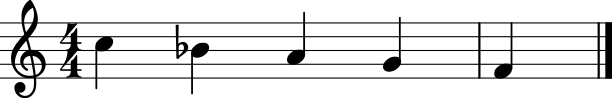

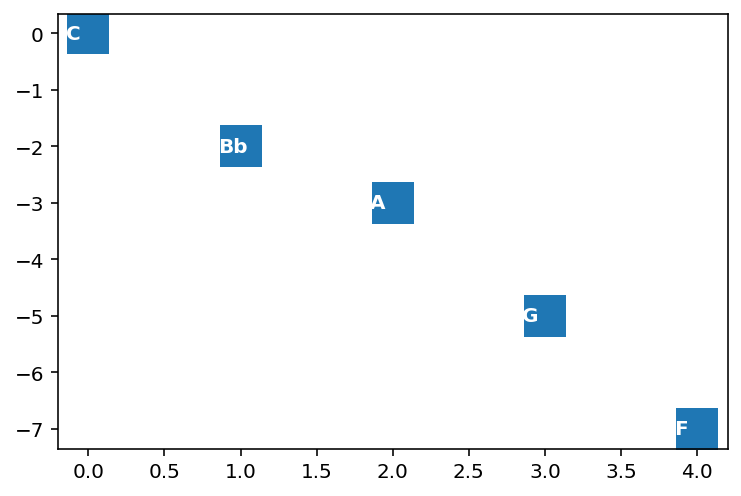

********************************************************************************
Apears in:		145 works from 6 composers (Beethoven,Schubert,Handel,Mozart,Chopin,Pachelbel)
Interval pattern:	-2 -2 -1 -2
Steps pattern:		0 -2 -4 -5 -7
Pitches pattern:	C Bb Ab G F


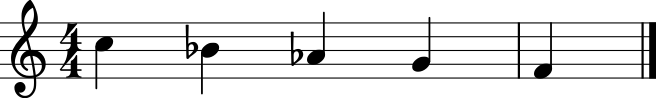

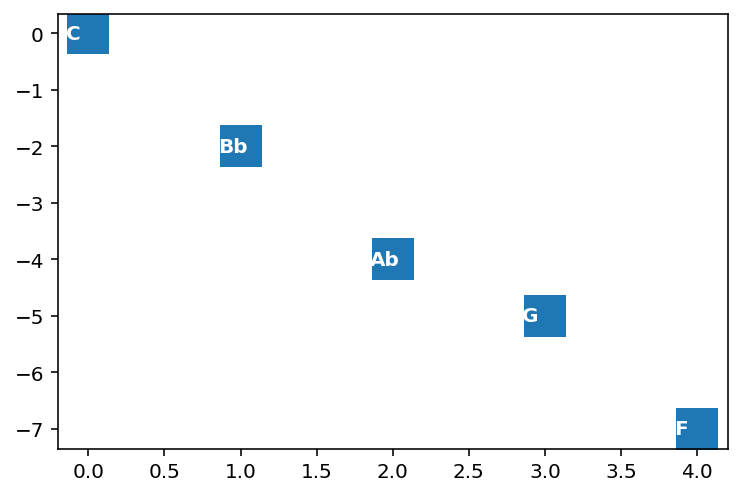

********************************************************************************
Apears in:		131 works from 5 composers (Beethoven,Schubert,Handel,Mozart,Chopin)
Interval pattern:	-1 -2 -2 -1
Steps pattern:		0 -1 -3 -5 -6
Pitches pattern:	C B A G Gb


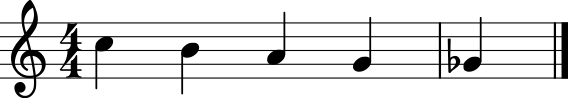

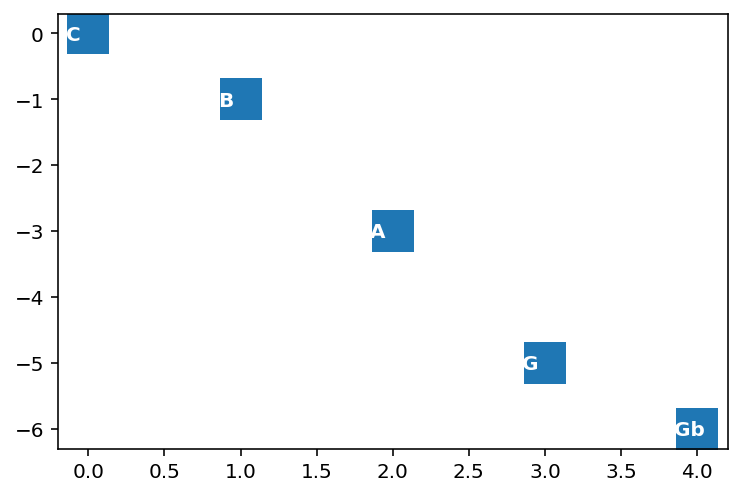

********************************************************************************
Apears in:		102 works from 5 composers (Beethoven,Schubert,Handel,Mozart,Chopin)
Interval pattern:	-2 -2 -1 -2 -2
Steps pattern:		0 -2 -4 -5 -7 -9
Pitches pattern:	C Bb Ab G F Eb


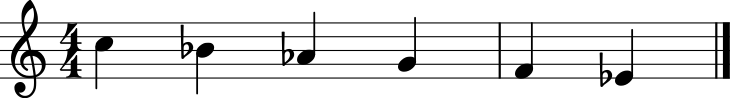

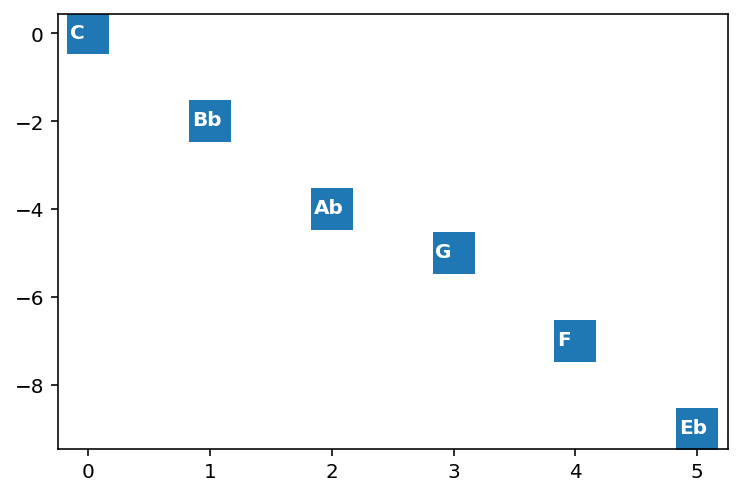

********************************************************************************
Apears in:		86 works from 6 composers (Beethoven,Schubert,Handel,Mozart,Chopin,Pachelbel)
Interval pattern:	-1 -2 -2 -2
Steps pattern:		0 -1 -3 -5 -7
Pitches pattern:	C B A G F


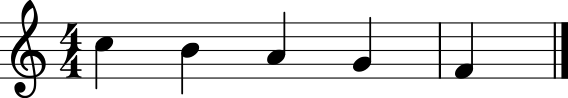

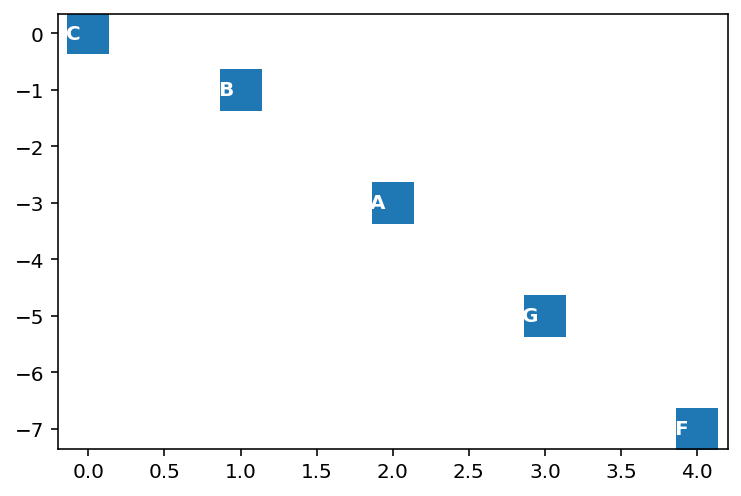

********************************************************************************


In [52]:
sql = '''
SELECT
    pattern_string,
    COUNT(DISTINCT(work_pattern.work_id)) as work_count,
    COUNT(DISTINCT(work_composer)) as composer_count,
    GROUP_CONCAT(DISTINCT(work_composer))
FROM pattern
JOIN work_pattern on pattern.pattern_id=work_pattern.pattern_id
JOIN work on work.work_id=work_pattern.work_id
GROUP BY pattern_string
HAVING work_count>5
AND LENGTH(pattern_string)>10
ORDER BY work_count DESC
LIMIT 5;'''

results = query_db(sql)
for row in results:
    interval_string = row[0]
    print(f"Apears in:\t\t{row[1]} works from {row[2]} composers ({row[3]})")
    plot_pattern(interval_string)